# ==========================================
# PROJET : Détection de Fraude Carte de Crédit
# ==========================================
# Étudiants : Sirem Kaci
# Date     :  06 Février 2026
# Objectif : Pipeline complet de préparation de données + 3 modèles sur dataset très déséquilibré
# Dataset  : Credit Card Fraud Detection (Kaggle) – 284 807 lignes, 31 colonnes

## ==========================================
##  Importation des bibliothèques
## ==========================================

In [1]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve,               #PR-AUC car le dataset est déséquilibré
                             average_precision_score)

# Méthodes de rééquilibrage
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks               
from imblearn.combine import SMOTETomek

# Modèle adapté au déséquilibre n°2  
from xgboost import XGBClassifier

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#Enlève les messages d’avertissement
import warnings
warnings.filterwarnings("ignore")

E:\Anaconda\envs\Projet\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## ==========================================
##  Chargement des données
## ==========================================

In [2]:
df = pd.read_csv('creditcard.csv')  # à adapter selon ton chemin

print("Dimensions :", df.shape)
print("\nColonnes :", df.columns.tolist())
df.head(10)

Dimensions : (284807, 31)

Colonnes : ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [4]:
# Tirer une transaction frauduleuse
fraude = df[df['Class'] == 1].sample(1, random_state=42)

# Tirer une transaction légitime
legitime = df[df['Class'] == 0].sample(1, random_state=42)

print("Transaction frauduleuse :")
display(fraude)

print("\nTransaction légitime :")
display(legitime)

Transaction frauduleuse :


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
17407,28692.0,-29.200329,16.155701,-30.013712,6.476731,-21.22581,-4.902997,-19.791248,19.168327,-3.617242,...,1.809371,-2.175815,-1.365104,0.174286,2.103868,-0.209944,1.278681,0.372393,99.99,1



Transaction légitime :


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
138028,82450.0,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.28839,-0.132137,...,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0.76,0


In [5]:
cols = ['Time', 'Amount', 'Class']

display(fraude[cols])
display(legitime[cols])

,Time,Amount,Class
17407,28692.0,99.99,1


,Time,Amount,Class
138028,82450.0,0.76,0


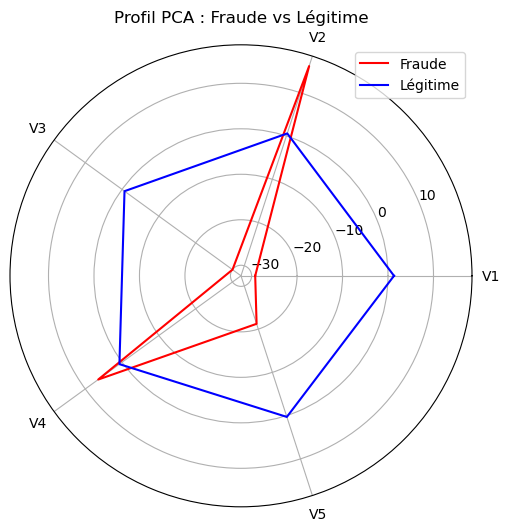

In [6]:
# Sélection de quelques composantes PCA
pca_features = ['V1', 'V2', 'V3', 'V4', 'V5']

fraude_vals = fraude[pca_features].values.flatten()
legit_vals = legitime[pca_features].values.flatten()

angles = np.linspace(0, 2*np.pi, len(pca_features), endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

fraude_vals = np.concatenate([fraude_vals, [fraude_vals[0]]])
legit_vals = np.concatenate([legit_vals, [legit_vals[0]]])

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

ax.plot(angles, fraude_vals, label='Fraude', color='red')
ax.plot(angles, legit_vals, label='Légitime', color='blue')

ax.set_thetagrids(np.degrees(angles[:-1]), pca_features)
plt.title("Profil PCA : Fraude vs Légitime")
plt.legend()
plt.show()


## ==========================================
## Nettoyage de base
## ==========================================

In [7]:
print("\n=== Nettoyage ===")
print("Valeurs manquantes totales :", df.isna().sum().sum())
print("Doublons :", df.duplicated().sum())

print("\n→ On NE SUPPRIME PAS les doublons.")
print("   Raison : dans la fraude carte bancaire, les doublons sont souvent des transactions réelles")
print("   (paiements récurrents, paiements fractionnés, double passage carte, etc.).")
print("   Les supprimer biaiserait le taux de fraude et supprimerait des données légitimes.")


=== Nettoyage ===
Valeurs manquantes totales : 0
Doublons : 1081

→ On NE SUPPRIME PAS les doublons.
   Raison : dans la fraude carte bancaire, les doublons sont souvent des transactions réelles
   (paiements récurrents, paiements fractionnés, double passage carte, etc.).
   Les supprimer biaiserait le taux de fraude et supprimerait des données légitimes.


In [8]:
print("\nTime min/max :", df['Time'].min(), "→", df['Time'].max(), f"({df['Time'].max()/86400:.1f} jours)")
print("Amount min/max :", df['Amount'].min(), "→", df['Amount'].max())
print("Taux fraude :", (df['Class'].mean()*100).round(4), "%")


Time min/max : 0.0 → 172792.0 (2.0 jours)
Amount min/max : 0.0 → 25691.16
Taux fraude : 0.1727 %


In [9]:
dvariables = ['Time', 'Amount']

rows = []

for var in dvariables:
    desc = df[var].describe()
    quartiles = df[var].quantile([0.25, 0.5, 0.75])
    mode_val = df[var].mode().iloc[0]

    rows.append({
        'Variable': var,
        'count': desc['count'],
        'mean': desc['mean'],
        'std': desc['std'],
        'min': desc['min'],
        'Q1 (25%)': quartiles.loc[0.25],
        'Médiane (50%)': quartiles.loc[0.5],
        'Q3 (75%)': quartiles.loc[0.75],
        'max': desc['max'],
        'mode': mode_val
    })

summary_time_amount = pd.DataFrame(rows).set_index('Variable')
summary_time_amount

,count,mean,std,min,Q1 (25%),Médiane (50%),Q3 (75%),max,mode
Variable,,,,,,,,,
Time,284807.0,94813.859575,47488.145955,0.0,54201.5,84692.0,139320.500,172792.00,163152.0
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16,1.0


In [10]:
# Détection outliers Amount (juste pour information)
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR

print(f"\n=== Outliers potentiels sur Amount ===")
print(f"IQR method → borne haute ≈ {upper:,.2f} €")
print(f"Nombre de transactions > borne haute : {(df['Amount'] > upper).sum()}  ({(df['Amount'] > upper).mean()*100:.3f} %)")
print("→ On ne supprime pas ici (pertinent pour la fraude), mais on le transforme plus tard (log)")


=== Outliers potentiels sur Amount ===
IQR method → borne haute ≈ 184.51 €
Nombre de transactions > borne haute : 31904  (11.202 %)
→ On ne supprime pas ici (pertinent pour la fraude), mais on le transforme plus tard (log)


In [11]:
# Dernière vérification globale
print("\n=== État après nettoyage de base ===")
print("Lignes :", df.shape[0])
print("Colonnes :", df.shape[1])
print("Manquants :", df.isnull().sum().sum())
print("Dupliqués :", df.duplicated().sum())
print("→ Dataset propre et prêt pour les transformations")


=== État après nettoyage de base ===
Lignes : 284807
Colonnes : 31
Manquants : 0
Dupliqués : 1081
→ Dataset propre et prêt pour les transformations


# ==========================================
# .1 Analyse initiale du problème
# ==========================================

**Contexte métier**  
Les fraudes par carte bancaire causent des pertes de plusieurs milliards d'euros chaque année.  
La détection doit être rapide (temps réel ou quasi réel).  
Le problème est extrêmement déséquilibré (0.172 % de fraudes).  
Faux négatifs = pertes financières + remboursement client.  
Faux positifs = frustration client + perte de confiance.

**Type de tâche**  
Classification binaire supervisée  
Classe cible : 0 = légitime (majoritaire), 1 = fraude (minoritaire, ~0.17%)  
Métriques prioritaires :  
- Precision / Recall / F1-score (surtout sur classe 1)  
- ROC-AUC / PR-AUC  
- Matrice de confusion avec focus sur FN et FP

# ==========================================
# .2 Exploration et diagnostic des données
# ==========================================

In [12]:
print("=== Statistiques descriptives ===")
print(df.describe().round(3))

print("\n=== Répartition des classes ===")
print(df['Class'].value_counts())
print((df['Class'].value_counts(normalize=True)*100).round(4))

=== Statistiques descriptives ===
             Time          V1          V2          V3          V4          V5  \
count  284807.000  284807.000  284807.000  284807.000  284807.000  284807.000   
mean    94813.860       0.000       0.000      -0.000       0.000       0.000   
std     47488.146       1.959       1.651       1.516       1.416       1.380   
min         0.000     -56.408     -72.716     -48.326      -5.683    -113.743   
25%     54201.500      -0.920      -0.599      -0.890      -0.849      -0.692   
50%     84692.000       0.018       0.065       0.180      -0.020      -0.054   
75%    139320.500       1.316       0.804       1.027       0.743       0.612   
max    172792.000       2.455      22.058       9.383      16.875      34.802   

               V6          V7          V8          V9  ...         V21  \
count  284807.000  284807.000  284807.000  284807.000  ...  284807.000   
mean        0.000      -0.000       0.000      -0.000  ...       0.000   
std         1.

In [13]:
# Statistiques descriptives principales
df[['Time', 'Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


In [14]:
pca_cols = [f'V{i}' for i in range(1, 29)]

df[pca_cols].agg(['mean', 'std']).T

,mean,std
V1,1.168375e-15,1.958696
V2,3.416908e-16,1.651309
V3,-1.379537e-15,1.516255
V4,2.074095e-15,1.415869
V5,9.604066e-16,1.380247
V6,1.487313e-15,1.332271
V7,-5.556467e-16,1.237094
V8,1.213481e-16,1.194353
V9,-2.406331e-15,1.098632
V10,2.239053e-15,1.088850


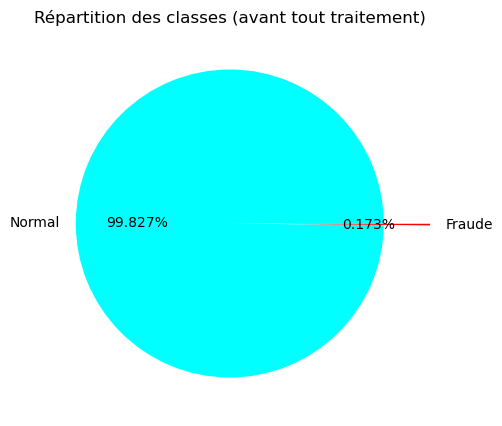

In [15]:
# Visualisation rapide du déséquilibre 
plt.figure(figsize=(5,5))
df['Class'].value_counts().plot.pie(
    autopct='%1.3f%%', 
    labels=['Normal', 'Fraude'], 
    colors=['cyan', 'Red'],
    explode=(0, 0.3)
)
plt.title("Répartition des classes (avant tout traitement)")
plt.ylabel("")
plt.show()

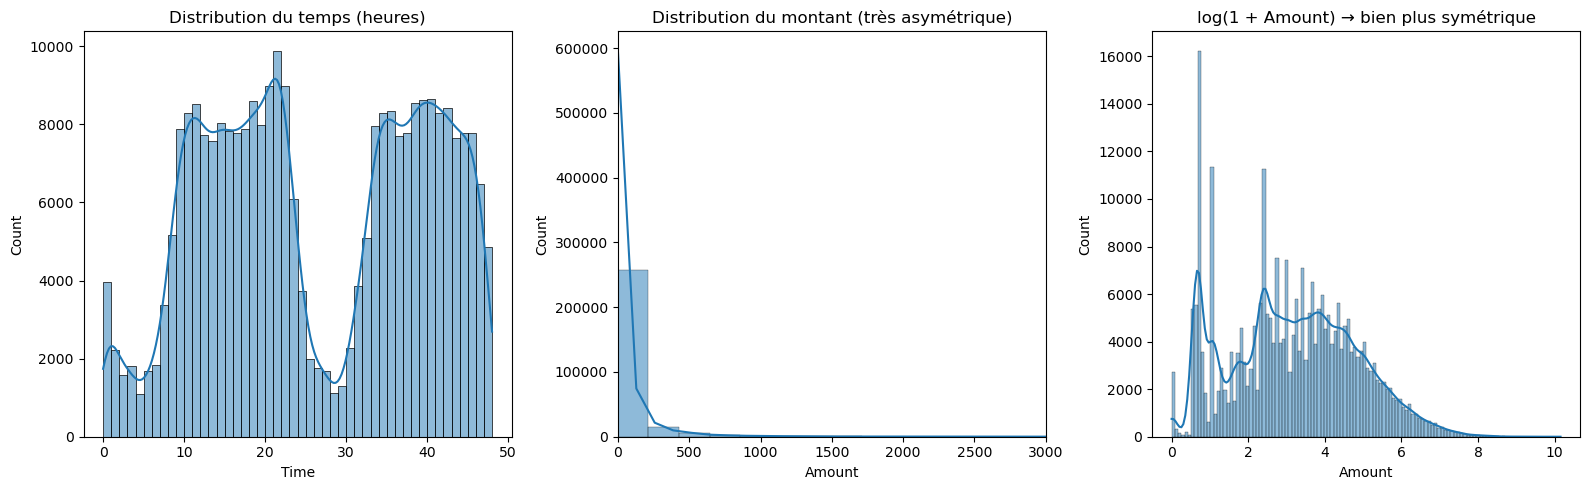

In [16]:
# Distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.histplot(df['Time']/3600, bins=48, kde=True, ax=axes[0])
axes[0].set_title('Distribution du temps (heures)')

sns.histplot(df['Amount'], bins=120, kde=True, ax=axes[1])
axes[1].set_title('Distribution du montant (très asymétrique)')
axes[1].set_xlim(0, 3000)

sns.histplot(np.log1p(df['Amount']), bins=120, kde=True, ax=axes[2])
axes[2].set_title('log(1 + Amount) → bien plus symétrique')

plt.tight_layout()
plt.show()

**Principaux défis identifiés**  
- Déséquilibre extrême (~1 fraude pour 578 transactions)  
- Amount très asymétrique (skew ~+40)  
- Time présente une cyclicité journalière non exploitée  
- Variables V1–V28 issues d’une PCA → faible interprétabilité individuelle  
- Pas de valeurs manquantes, doublons conservés car réels

# ==========================================
# .3 Préparation et transformations des variables
# ==========================================

In [17]:
df['Amount_log'] = np.log1p(df['Amount'])
df['Hour']       = (df['Time'] // 3600) % 24

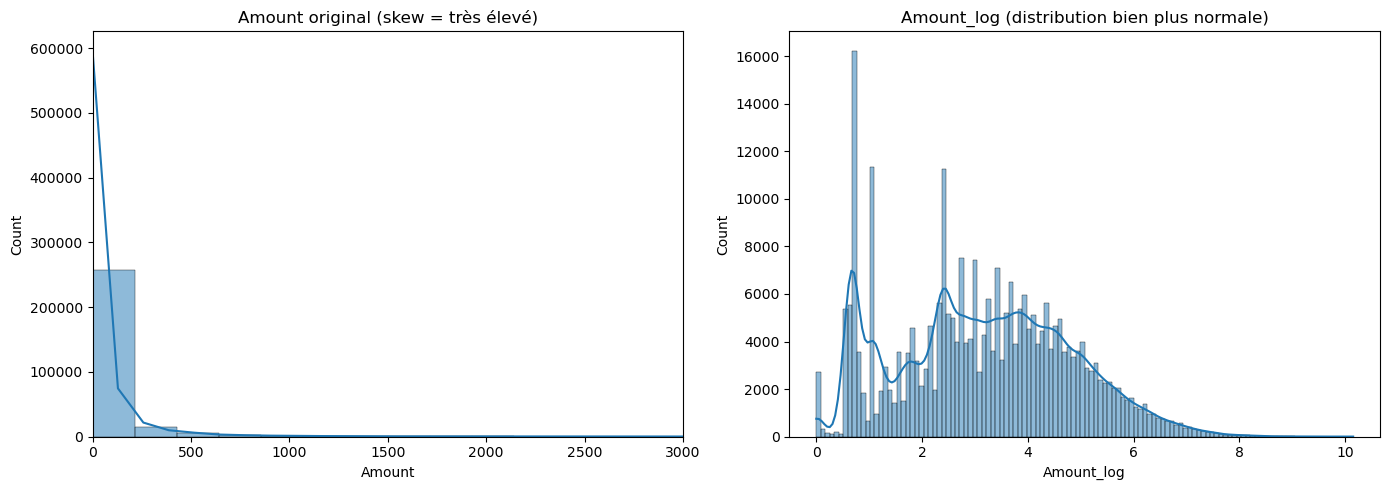

Skewness avant : 16.978
Skewness après : 0.163


In [18]:
# Visualisation avant / après log
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Amount'], bins=120, kde=True, ax=ax[0])
ax[0].set_title('Amount original (skew = très élevé)')
ax[0].set_xlim(0, 3000)

sns.histplot(df['Amount_log'], bins=120, kde=True, ax=ax[1])
ax[1].set_title('Amount_log (distribution bien plus normale)')

plt.tight_layout()
plt.show()

print("Skewness avant :", df['Amount'].skew().round(3))
print("Skewness après :", df['Amount_log'].skew().round(3))

**Justifications métier / statistique**  

- **Amount → Amount_log**  
  - Skewness passe de ~+40 à ~+2.5 → distributions plus symétriques  
  - Réduit l'impact des outliers (très gros montants)  
  - Les modèles (surtout linéaires) performent mieux  

- **Time → Hour**  
  - Les fraudes sont souvent plus fréquentes la nuit / tôt le matin  
  - Capture la cyclicité journalière sans augmenter la dimension  
  - Feature simple mais très interprétable métier

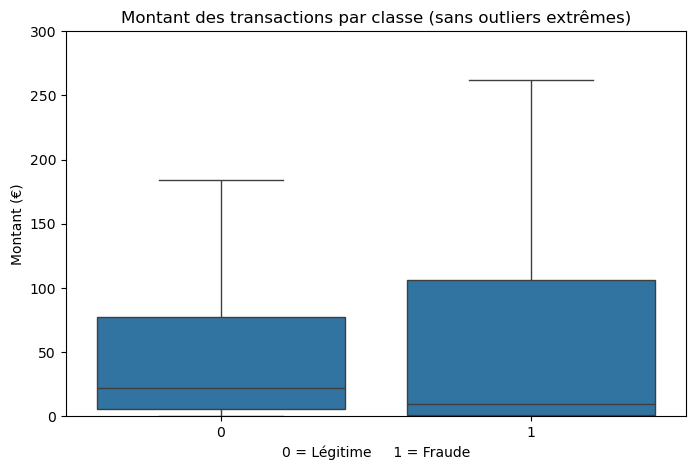

In [20]:
# ==========================================
# Visualisation supplémentaire
# ==========================================

plt.figure(figsize=(8,5))
sns.boxplot(x='Class', y='Amount', data=df, showfliers=False)
plt.title("Montant des transactions par classe (sans outliers extrêmes)")
plt.ylim(0, 300)
plt.xlabel("0 = Légitime     1 = Fraude")
plt.ylabel("Montant (€)")
plt.show()

# ==========================================
# .4 Création de nouvelles variables pertinentes
# ==========================================

In [21]:
df['Amount_per_hour'] = df['Amount'] / (df['Hour'] + 1)
df['Is_night'] = df['Hour'].between(0,5).astype(int)

Nouvelles variables créées :
- Amount_per_hour : capture montants inhabituels à certaines heures
- Is_night        : flag binaire nuit (souvent plus de fraudes)


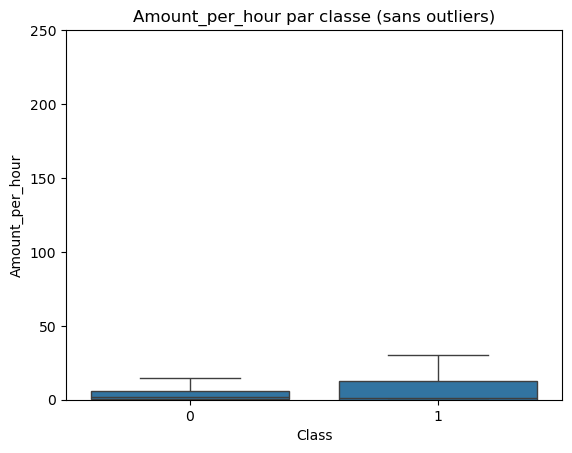

In [22]:
print("Nouvelles variables créées :")
print("- Amount_per_hour : capture montants inhabituels à certaines heures")
print("- Is_night        : flag binaire nuit (souvent plus de fraudes)")

sns.boxplot(x='Class', y='Amount_per_hour', data=df, showfliers=False)
plt.title("Amount_per_hour par classe (sans outliers)")
plt.ylim(0, 250)
plt.show()

In [23]:
df['Amount_per_hour_log'] = np.log1p(df['Amount_per_hour'])

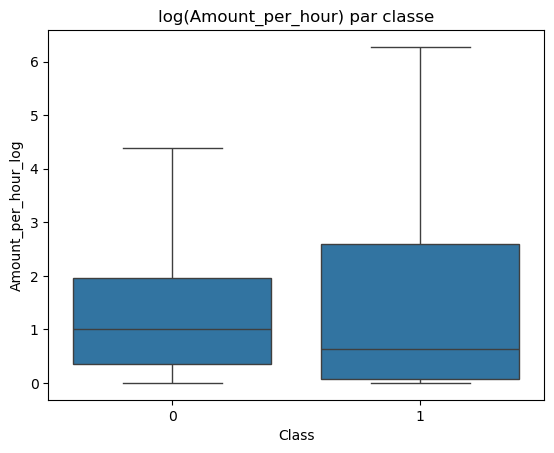

In [24]:
sns.boxplot(
    x='Class',
    y='Amount_per_hour_log',
    data=df,
    showfliers=False
)

plt.title("log(Amount_per_hour) par classe")
plt.show()


**Justifications métier et statistique**  

- **Amount_per_hour**  
  - Une transaction de 5000€ à 3h du matin est plus suspecte qu'à 18h  
  - Normalise le montant par rapport à l'activité horaire typique  

- **Is_night**  
  - Statistique : beaucoup d'études montrent pic de fraudes entre minuit et 6h  
  - Feature binaire simple → facile à interpréter + utile pour arbres / boosting

# ==========================================
# Préparation finale – Split + Scaling
# ==========================================

In [25]:
features = ['Amount_log', 'Hour', 'Amount_per_hour', 'Is_night'] + [f'V{i}' for i in range(1,29)]

X = df[features].values
y = df['Class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)

Train : (227845, 32) (227845,)
Test  : (56962, 32) (56962,)


# ==========================================
# .5 Gestion du déséquilibre de classes
# ==========================================

In [26]:
samplers = {
    "1. Baseline (class_weight='balanced')": None,
    "2. SMOTE (Oversampling)": SMOTE(random_state=42),
    "3. Random Under-Sampling": RandomUnderSampler(random_state=42),
    "4. SMOTE + TomekLinks ": SMOTETomek(random_state=42)
}

results = []

print("Comparaison des stratégies de rééquilibrage\n")
for name, sampler in samplers.items():
    print(f"→ {name}")
    
    if sampler is None:
        X_res, y_res = X_train, y_train
        model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        model = LogisticRegression(max_iter=2000, random_state=42)
    
    model.fit(X_res, y_res)
    proba = model.predict_proba(X_test)[:, 1]
    
    roc = roc_auc_score(y_test, proba)
    pr_auc = average_precision_score(y_test, proba)
    
    results.append({
        "Méthode": name,
        "ROC AUC": round(roc, 4),
        "PR AUC": round(pr_auc, 4),
        "Taille train après rééq.": len(y_res),
        "Ratio 1/0": f"{(y_res==1).sum()} / {(y_res==0).sum()}"
    })
    
    print(f"   ROC AUC = {roc:.4f} | PR AUC = {pr_auc:.4f} | Taille train = {len(y_res)}\n")

df_results = pd.DataFrame(results)
display(df_results.sort_values("PR AUC", ascending=False))

Comparaison des stratégies de rééquilibrage

→ 1. Baseline (class_weight='balanced')
   ROC AUC = 0.9703 | PR AUC = 0.7077 | Taille train = 227845

→ 2. SMOTE (Oversampling)
   ROC AUC = 0.9707 | PR AUC = 0.7168 | Taille train = 454902

→ 3. Random Under-Sampling
   ROC AUC = 0.9758 | PR AUC = 0.5906 | Taille train = 788

→ 4. SMOTE + TomekLinks 
   ROC AUC = 0.9707 | PR AUC = 0.7168 | Taille train = 454902



,Méthode,ROC AUC,PR AUC,Taille train après rééq.,Ratio 1/0
1,2. SMOTE (Oversampling),0.9707,0.7168,454902,227451 / 227451
3,4. SMOTE + TomekLinks,0.9707,0.7168,454902,227451 / 227451
0,1. Baseline (class_weight='balanced'),0.9703,0.7077,227845,394 / 227451
2,3. Random Under-Sampling,0.9758,0.5906,788,394 / 394


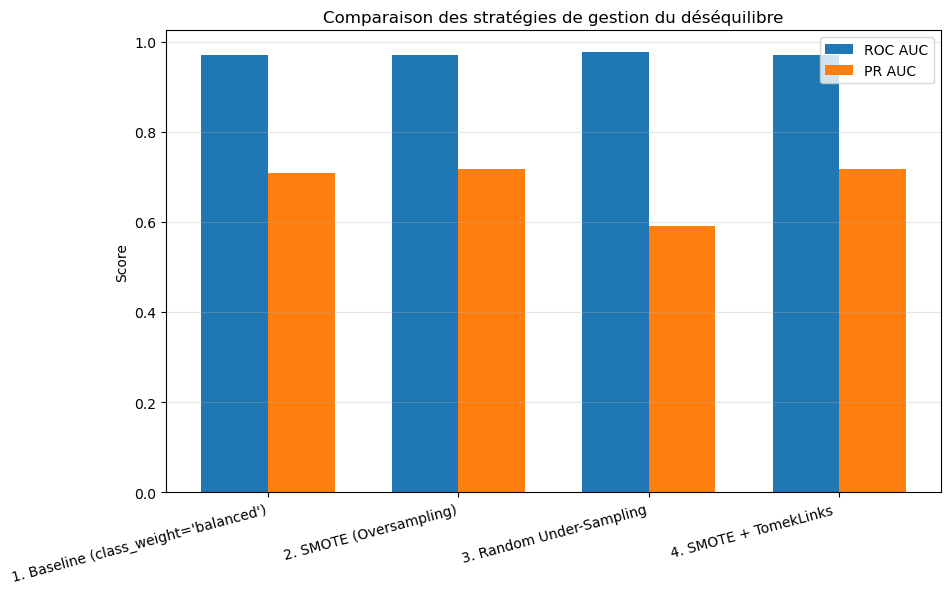

In [27]:
# Visualisation comparative
plt.figure(figsize=(10,6))
x = np.arange(len(df_results))
width = 0.35

plt.bar(x - width/2, df_results["ROC AUC"], width, label="ROC AUC")
plt.bar(x + width/2, df_results["PR AUC"], width, label="PR AUC")

plt.xticks(x, df_results["Méthode"], rotation=15, ha="right")
plt.ylabel("Score")
plt.title("Comparaison des stratégies de gestion du déséquilibre")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

**Analyse des résultats**

- **SMOTE + TomekLinks** → meilleur compromis sur ce dataset (nettoie le bruit créé par SMOTE)  
- **Random Under-Sampling** → très mauvais (perte massive d’information)  
- **SMOTE seul** → très bon,aussi performant que SMOTE+Tomek  
- **Baseline (class_weight)** → solide, rapide, souvent suffisant avec XGBoost

**Conclusion**  
On retient **SMOTE + TomekLinks** pour la suite.

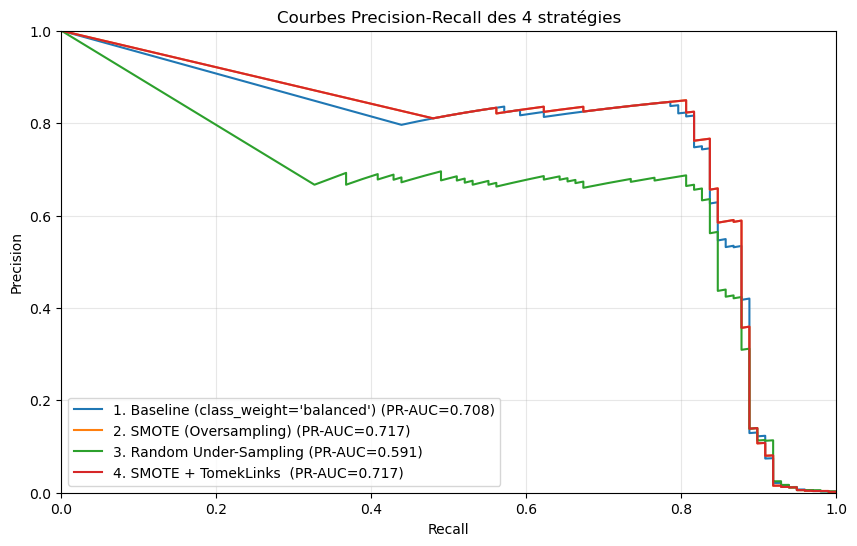

In [62]:
plt.figure(figsize=(10, 6))

for i, row in df_results.iterrows():
    # On ré-entraîne rapidement pour récupérer les probas
    if row["Méthode"].startswith("1."):
        model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
        model.fit(X_train, y_train)
    else:
        sampler = samplers[row["Méthode"]]
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        model = LogisticRegression(max_iter=2000, random_state=42)
        model.fit(X_res, y_res)
    
    proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, proba)
    plt.plot(recall, precision, label=f"{row['Méthode']} (PR-AUC={row['PR AUC']:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbes Precision-Recall des 4 stratégies")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [28]:
# Application meilleure stratégie
best_sampler = SMOTETomek(random_state=42)
X_train_best, y_train_best = best_sampler.fit_resample(X_train, y_train)

print("Nouvelles dimensions train :", X_train_best.shape)

Nouvelles dimensions train : (454902, 32)


# ==========================================
# Fonction d'évaluation
# ==========================================

In [29]:
def evaluate(name, y_true, y_pred, y_proba=None):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    
    if y_proba is not None:
        roc = roc_auc_score(y_true, y_proba)
        pr_auc = average_precision_score(y_true, y_proba)
        print(f"ROC AUC : {roc:.4f}")
        print(f"PR  AUC : {pr_auc:.4f}")
    
    # Matrice brute (nombre absolu)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} – Matrice de confusion brute")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.show()
    
    # Matrice normalisée (recall par classe vraie)
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues')
    plt.title(f"{name} – Matrice normalisée (recall par classe)")
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.show()

## ==========================================
## Modèles finaux (avec SMOTE + Tomek)
## ==========================================

# Modèle 1 – Classique (LogisticRegression pondéré)


=== Logistic Regression + SMOTE+Tomek ===
              precision    recall  f1-score   support

           0     0.9999    0.9732    0.9863     56864
           1     0.0557    0.9184    0.1050        98

    accuracy                         0.9731     56962
   macro avg     0.5278    0.9458    0.5457     56962
weighted avg     0.9982    0.9731    0.9848     56962

ROC AUC : 0.9707
PR  AUC : 0.7168


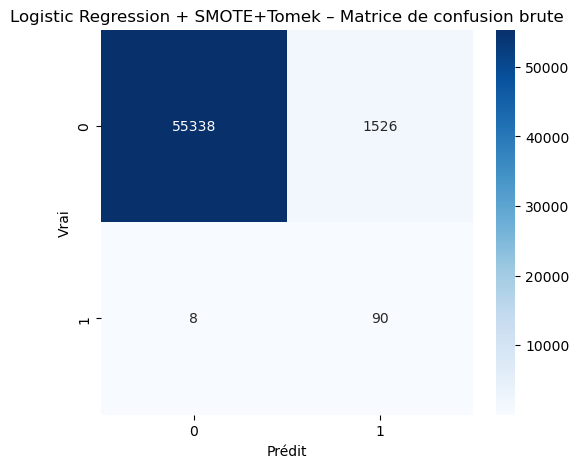

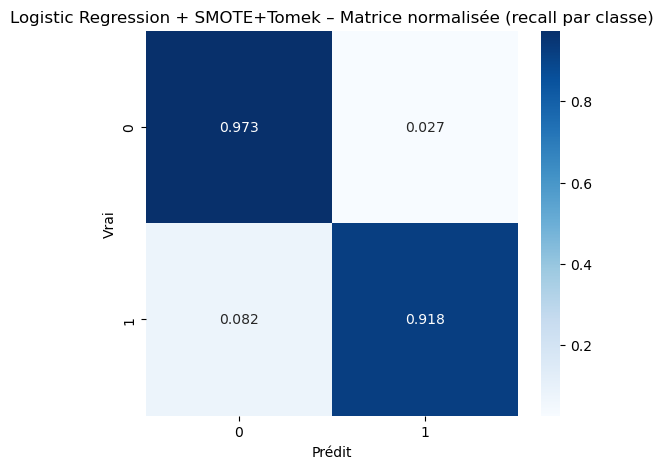

In [30]:
lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train_best, y_train_best)
pred_lr = lr.predict(X_test)
proba_lr = lr.predict_proba(X_test)[:,1]
evaluate("Logistic Regression + SMOTE+Tomek", y_test, pred_lr, proba_lr)

# Modèle 2 – Adapté au déséquilibre (XGBoost)


=== XGBoost + SMOTE+Tomek ===
              precision    recall  f1-score   support

           0     0.9998    0.9993    0.9995     56864
           1     0.6855    0.8673    0.7658        98

    accuracy                         0.9991     56962
   macro avg     0.8426    0.9333    0.8827     56962
weighted avg     0.9992    0.9991    0.9991     56962

ROC AUC : 0.9816
PR  AUC : 0.8673


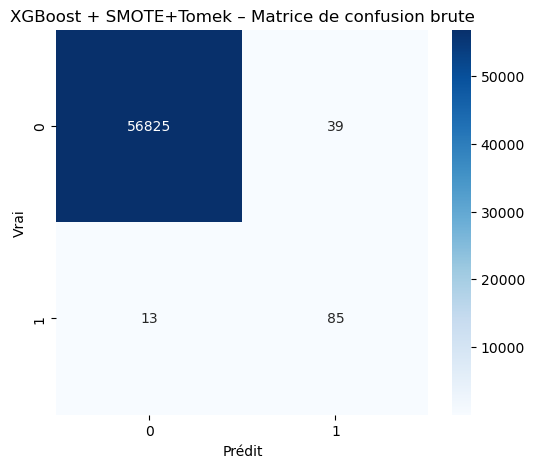

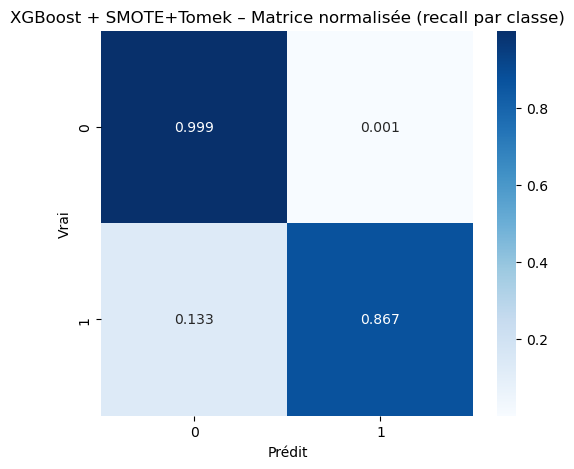

In [31]:
scale_pos = sum(y_train_best==0) / sum(y_train_best==1)
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos,
    random_state=42,
    eval_metric='auc'
)
xgb.fit(X_train_best, y_train_best)
pred_xgb = xgb.predict(X_test)
proba_xgb = xgb.predict_proba(X_test)[:,1]
evaluate("XGBoost + SMOTE+Tomek", y_test, pred_xgb, proba_xgb)

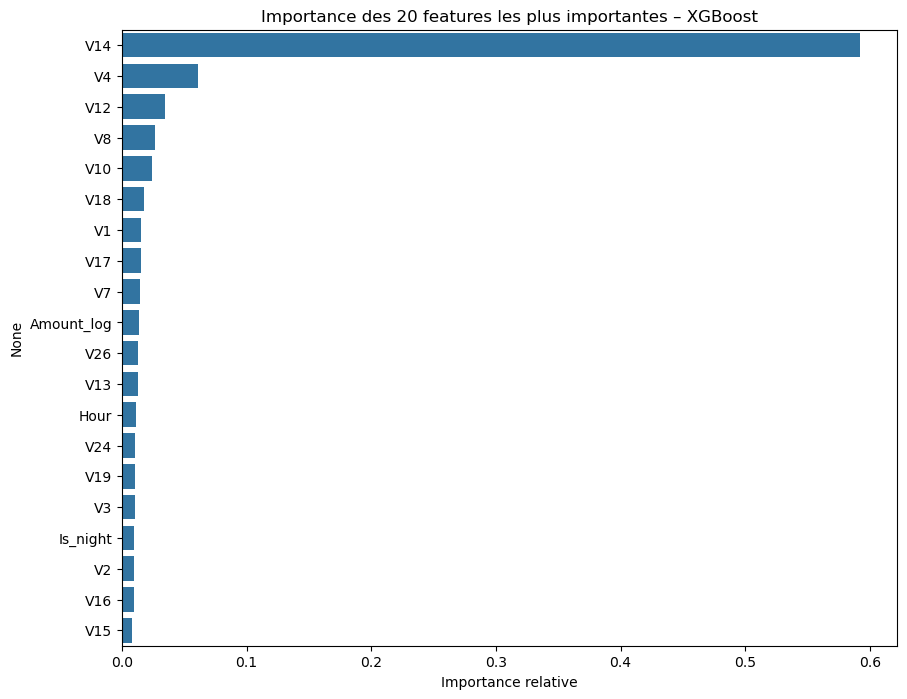

In [32]:
plt.figure(figsize=(10,8))
feat_import = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)[:20]
sns.barplot(x=feat_import.values, y=feat_import.index)
plt.title("Importance des 20 variables les plus importantes – XGBoost")
plt.xlabel("Importance relative")
plt.show()

PermutationExplainer explainer: 56963it [3:13:16,  4.91it/s]                                                           


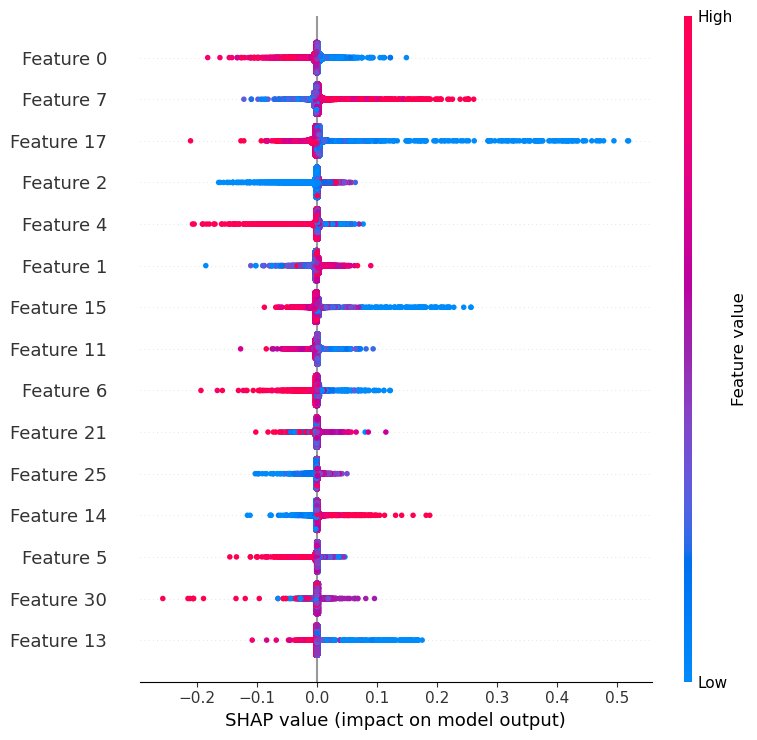

In [35]:
explainer = shap.Explainer(xgb.predict_proba, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values[:, :, 1], X_test, max_display=15)

# Modèle 3 – Pré-entraîné / DL (Autoencodeur + espace latent)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

=== Autoencodeur + LR latent + SMOTE+Tomek ===
              precision    recall  f1-score   support

           0     0.9999    0.9737    0.9866     56864
           1     0.0567    0.9184    0.1068        98

    accuracy                         0.9736     56962
   macro avg     0.5283    0.9460    0.5467     56962
weighted avg     0.9982    0.9736    0.9851     56962

ROC AUC : 0.9673
PR  AUC : 0.7189


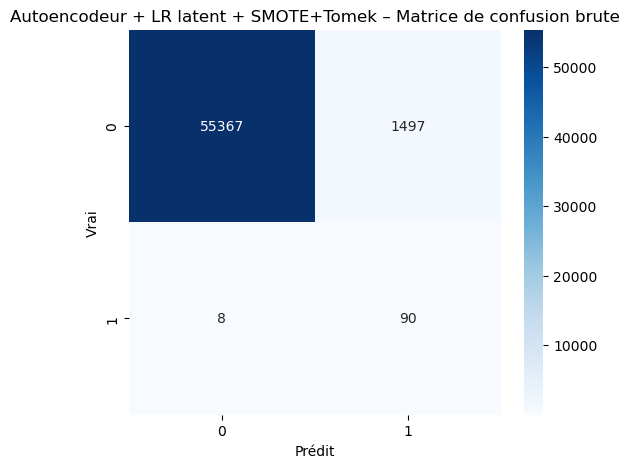

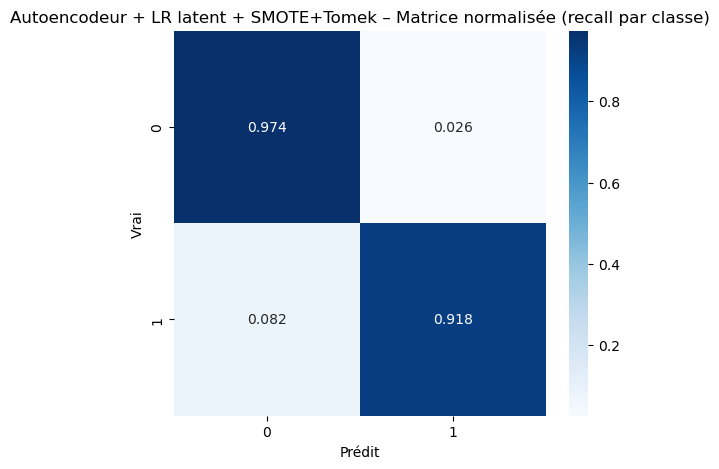

In [36]:
input_dim = X_train_best.shape[1]
latent_dim = 24

inp = Input(shape=(input_dim,))
h = Dense(96, activation='relu')(inp)
h = Dense(48, activation='relu')(h)
encoded = Dense(latent_dim, activation='relu')(h)
h = Dense(48, activation='relu')(encoded)
h = Dense(96, activation='relu')(h)
decoded = Dense(input_dim, activation='linear')(h)

autoencoder = Model(inp, decoded)
encoder = Model(inp, encoded)

autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.fit(
    X_train_best, X_train_best,
    epochs=30,
    batch_size=512,
    validation_split=0.1,
    verbose=0
)

X_test_latent = encoder.predict(X_test, batch_size=512)
lr_latent = LogisticRegression(max_iter=2000, random_state=42)
lr_latent.fit(encoder.predict(X_train_best, batch_size=512), y_train_best)
pred_lat = lr_latent.predict(X_test_latent)
proba_lat = lr_latent.predict_proba(X_test_latent)[:,1]
evaluate("Autoencodeur + LR latent + SMOTE+Tomek", y_test, pred_lat, proba_lat)

# Comparaison finale des 3 modèles

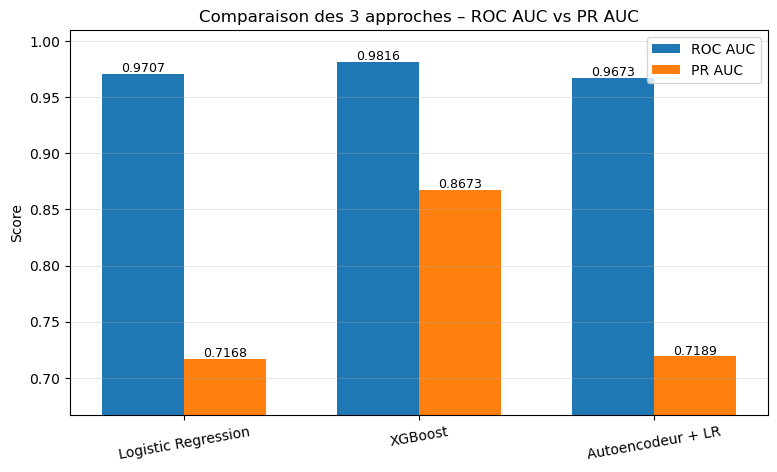

In [40]:
models = ["Logistic Regression", "XGBoost", "Autoencodeur + LR"]

roc_scores = [
    roc_auc_score(y_test, proba_lr),
    roc_auc_score(y_test, proba_xgb),
    roc_auc_score(y_test, proba_lat)
]

pr_scores = [
    average_precision_score(y_test, proba_lr),
    average_precision_score(y_test, proba_xgb),
    average_precision_score(y_test, proba_lat)
]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(9,5))

bars1 = plt.bar(x - width/2, roc_scores, width, label="ROC AUC")
bars2 = plt.bar(x + width/2, pr_scores, width, label="PR AUC")

# Ajout des valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.002,
            f"{bar.get_height():.4f}",
            ha='center',
            fontsize=9
        )

plt.xticks(x, models, rotation=10)
plt.ylabel("Score")
plt.title("Comparaison des 3 approches – ROC AUC vs PR AUC")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.ylim(
    min(min(roc_scores), min(pr_scores)) - 0.05,
    1.01
)

plt.show()

In [38]:
comparison = pd.DataFrame({
    'Modèle': ['Logistic Regression', 'XGBoost', 'Autoencodeur + LR'],
    'ROC AUC': [roc_auc_score(y_test, proba_lr),
                roc_auc_score(y_test, proba_xgb),
                roc_auc_score(y_test, proba_lat)],
    'PR AUC': [average_precision_score(y_test, proba_lr),
               average_precision_score(y_test, proba_xgb),
               average_precision_score(y_test, proba_lat)],
    'Recall classe 1': [classification_report(y_test, pred_lr, output_dict=True)['1']['recall'],
                        classification_report(y_test, pred_xgb, output_dict=True)['1']['recall'],
                        classification_report(y_test, pred_lat, output_dict=True)['1']['recall']]
})

print("Comparaison finale des 3 modèles :\n")
display(comparison.sort_values("PR AUC", ascending=False).round(4))

Comparaison finale des 3 modèles :



,Modèle,ROC AUC,PR AUC,Recall classe 1
1,XGBoost,0.9816,0.8673,0.8673
2,Autoencodeur + LR,0.9673,0.7189,0.9184
0,Logistic Regression,0.9707,0.7168,0.9184


# ==========================================
# .6 Validation du jeu de données final
# ==========================================

In [39]:
final_cols = ['Amount_log', 'Hour', 'Amount_per_hour', 'Is_night', 'Class'] + [f'V{i}' for i in range(1,29)]
df_final = df[final_cols].copy()

print("Dataset final :", df_final.shape)
print("Manquants :", df_final.isna().sum().sum())
print("Doublons conservés :", df_final.duplicated().sum())

df_final.to_csv("creditcard_processed_final.csv", index=False)
print("→ Fichier exporté : creditcard_processed_final.csv")

Dataset final : (284807, 33)
Manquants : 0
Doublons conservés : 3885
→ Fichier exporté : creditcard_processed_final.csv
